In [274]:
import json
import os
import sklearn
from keras.preprocessing import image
from PIL import Image
import numpy as np
from keras.applications import InceptionV3
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,GRU,Embedding,concatenate
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

In [207]:
tf.enable_eager_execution()

In [208]:
trainData = pd.read_csv("/home/nishimehta15/NIC/flickr/trainImages.txt", delimiter='\t')
images_path = "/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/"
trainData.head(5)

,2513260012_03d33305cf.jpg,<start> A black dog is running after a white dog in the snow . <end>
0,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
1,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
2,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
3,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...
4,2903617548_d3e38d7f88.jpg,<start> A little baby plays croquet . <end>


In [209]:
captions = []
image_names = []
for row in trainData.iterrows():
    captions.append(row[1][1])
    image_names.append(images_path + str(row[1][0]))

In [228]:
testData = pd.read_csv("/home/nishimehta15/NIC/flickr/testImages.txt", delimiter='\t')
testData.head(5)
captions_val = []
image_names_val = []
for row in testData.iterrows():
    captions_val.append(row[1][1])
    image_names_val.append(images_path + str(row[1][0]))

In [211]:
captions[:5]

['<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>',
 '<start> A little baby plays croquet . <end>']

In [212]:
image_names[:5]

['/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/2513260012_03d33305cf.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/2513260012_03d33305cf.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/2513260012_03d33305cf.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/2513260012_03d33305cf.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/2903617548_d3e38d7f88.jpg']

In [213]:
def preprocess_images(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 127.5
    x -= 1
    return x,image_path

In [214]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [215]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet')
new_input = inception_model.input
encoded = inception_model.layers[-2].output
inception_model_feat = tf.keras.Model(new_input, encoded)

In [11]:
def encode_inception(image_path):
    img = preprocess_images(image_path)
    encoding = inception_model_feat.predict(img)
    encoding = np.reshape(encoding,encoding.shape[1])
    return encoding

In [45]:
encode_train = sorted(set(image_names))


In [46]:
encode_train[:5]

['/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/1002674143_1b742ab4b8.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/1003163366_44323f5815.jpg',
 '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/1007129816_e794419615.jpg']

In [47]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = inception_model_feat(img)
    batch_features = tf.reshape(batch_features,(16,batch_features.shape[1]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
    

In [ ]:
# samples = 20000
# caption_list = caption_list[:samples]
# image_paths = image_paths[:samples]

# encoding_train = {}
# for image_path in tqdm(image_paths): 
#     encoding_train[image_path] = encode(image_path)

In [48]:
vocab = Tokenizer(num_words=5000,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',oov_token="<empty>")
vocab.fit_on_texts(captions)

vocab.word_index['<pad>'] = 0
vocab.index_word[0] = '<pad>'
vocab_seqs = vocab.texts_to_sequences(captions)

padded_captions = pad_sequences(vocab_seqs, padding='post')
max_length_caption = max(len(s) for s in vocab_seqs)

In [128]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.layer_output = tf.keras.layers.Dense(1)
        self.layer1 = tf.keras.layers.Dense(units)
        self.layer2 = tf.keras.layers.Dense(units)

    def call(self, input_, hidden):
        input_ = tf.cast(input_, tf.float32)
        hidden = tf.cast(hidden, tf.float32)
        hidden_layer_shape = tf.expand_dims(hidden, 1)
        combined_input = self.layer1(input_) + self.layer2(hidden_layer_shape)
        correlation = tf.nn.tanh(combined_input)
#         correlation = tf.nn.tanh(combined_input)
        attention_vector = tf.nn.softmax(self.layer_output(correlation), axis=1)
        output_ = attention_vector * input_
        context_vector = tf.reduce_sum(output_, axis=1)
        return context_vector, output_

In [129]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.layer1 = tf.keras.layers.Dense(embedding_dim)

    def call(self, input_):
        out = self.layer1(input_)
        out = tf.nn.relu(out)
        return out

In [130]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention_layer = BahdanauAttention(units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.layer1 = tf.keras.layers.Dense(units)
        self.layer2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention_layer(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.layer1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.layer2(x)
        return x, state, attention_weights

In [132]:
dim = 256
units = 512
vocab_size = len(vocab.word_index) + 1

encoder = Encoder(dim)
decoder = Decoder(dim, units, vocab_size)

In [126]:
def get_hidden_layer(batch_size):
    return np.zeros((batch_size,units))

In [68]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [56]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


In [219]:
train_seqs = vocab.texts_to_sequences(captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = max(len(t) for t in train_seqs)

In [267]:
image_names = image_names[:24000]
cap_vector = cap_vector[:24000]

In [280]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
num_steps = len(image_names) // BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((image_names, cap_vector))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.apply(tf.contrib.data.unbatch())
# dataset = dataset.batch(BATCH_SIZE)
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [281]:
checkpoint_path = "/home/nishimehta15/NIC/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [282]:
loss_plot = []

In [283]:
def train_step(img_tensor, target):
    loss = 0
    hidden = get_hidden_layer(target.shape[0])

    dec_input = tf.expand_dims([vocab.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8118


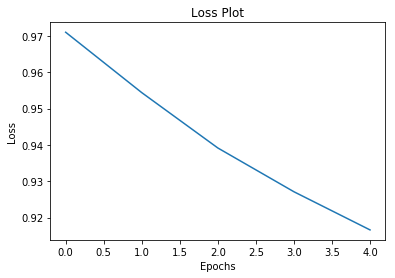

In [223]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 2048))

    hidden = get_hidden_layer(1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model_feat(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, [1,img_tensor_val.shape[1]])

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([vocab.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(vocab.index_word[predicted_id])

        if vocab.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [226]:
test_seqs = vocab.texts_to_sequences(captions_val)
captions_test = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

Real Caption: <start> small boy sleeping on seats and sucking his thumb <end>
Prediction Caption: a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in
0.04310344827586208


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


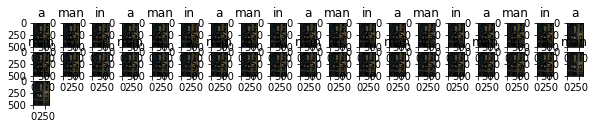

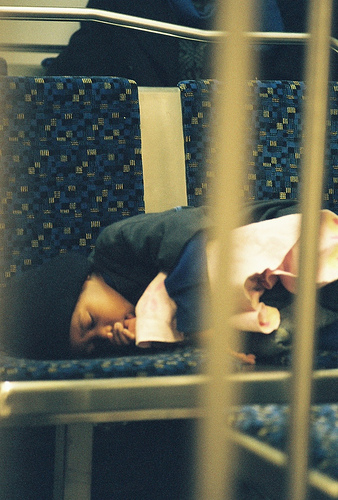

In [276]:
# captions on the validation set

rid = np.random.randint(0, len(image_names_val))
image = image_names_val[rid]
real_caption = ' '.join([vocab.index_word[i] for i in captions_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
bleu_score = sentence_bleu(real_caption,' '.join(result),weights=(1, 0, 0, 0))
print(bleu_score)
plot_attention(image, result, attention_plot)
# opening the image
Image.open(image_names_val[rid])

In [278]:
bleu_scores = []
for i in tqdm(range(len(image_names_val)-4000)):
    image = image_names_val[i]
    real_caption = ' '.join([vocab.index_word[i] for i in captions_test[rid] if i not in [0]])
    result, attention_plot = evaluate(image)
    bleu_score = sentence_bleu(real_caption,' '.join(result),weights=(1, 0, 0, 0))
    bleu_scores.append(bleu_score)
    

In [279]:
print(np.mean(bleu_scores))

0.3344695330729554
